# A/B test analysis

<b> Table of Contents: </b>

1. [Introduction](#introduction)
2. [General information](#general)
    * [Conclusion](#conclusion)
3. [Data preprocessing](#preprocessing)
    * [Conclusion](#conclusion1)
4. [Prioritizing hypotheses](#hypotheses)
    * [ICE](#ice)
    * [RICE](#rice)
    * [Conclusion](#conclusion2)
5. [A/B test analysis](#ab)
    * [Cumulative revenue](#cum_rev)
    * [Cumulative order size](#cum_order)
    * [Relative difference in cumulative average order size per groups](#relative_avg)
    * [Conversion rate](#conversion)
    * [Number of orders per user](#n_orders)
    * [Order price](#order_price)
    * [Comparison of statistical significance between raw and filtered data](#stat_sign)
        * [Raw data. Statistical significance of the difference in conversion between the groups](#conversion_raw)
        * [Raw data. Statistical significance of the difference in average order size between the groups](#order_size_raw)
        * [Filtering the data](#filtering)
        * [Filtered data. Statistical significance of the difference in conversion between the groups](#conversion_filt)
        * [Filtered data. Statistical significance of the difference in average order size between the groups](#order_size_filt)
6. [Overall conclusion](#conclusion3)

<a id="introduction"></a>
## Introduction
<b>Project description:</b>
As an analyst in a big online store, we're going to prioritize hypotheses we've come up together with the marketing department to boost the revenue. Then we're going to launch an A/B test, and analyze the results.

<b>Project structure:</b>

1. General information and data preparation. We're going to take a look at the data we have, check whether it has no errors and prepare it for analysis.
2. Prioritizing Hypotheses. We're going to choose one of the nine hypotheses on boosting an online store's revenue.
3. A/B Test Analysis. We're going to analyse the results we've got after launching an A/B test.
4. We'll present the overall conclusion and advice for business.

<a id="general"></a>
## General information

In [1]:
!pip install -Uq seaborn
!pip install -Uq sidetable

*! be sure to install updates, otherwise some blocks may not work* 

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import sidetable
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
try:
    hypotheses = pd.read_csv('hypotheses_us.csv', sep=';')
except:
    print('Error while loading the file')

In [4]:
try:
    visits = pd.read_csv('visits_us.csv')
except:
    print('Error while loading the file')

In [5]:
try:
    orders = pd.read_csv('orders_us.csv')
except:
    print('Error while loading the file')

In [6]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


As expected in this table we have only 9 rows, each row symbolyzing a hypothesis, and 5 columns. We can take a look at the whole table. Additionally, there's one object type variable with a description of hypothesis, and 4 `int64` variables, which we could have changed into `int16` or even `int8`, but it doesn't matter as the table is already this small.

In [7]:
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


We can't exactly see what's written there, so let's take a look at the full text.

In [8]:
pd.set_option('display.max_colwidth', None)
hypotheses[['Hypothesis']]

,Hypothesis
0,Add two new channels for attracting traffic. This will bring 30% more users
1,Launch your own delivery service. This will shorten delivery time
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size
3,Change the category structure. This will increase conversion since users will find the products they want more quickly
4,Change the background color on the main page. This will increase user engagement
5,Add a customer review page. This will increase the number of orders
6,Show banners with current offers and sales on the main page. This will boost conversion
7,Add a subscription form to all the main pages. This will help you compile a mailing list
8,Launch a promotion that gives users discounts on their birthdays


*Conclusion*: we can already see that we don't have any missing data, or unlogical values in numeric variables. This table is ready for analysis.

In [9]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [10]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [11]:
visits.tail()

,date,group,visits
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490
61,2019-08-31,B,718


There's another small dataset with only 62 rows and 3 columns, the data is preaggregated, and looks sorted by `date` and by `group`. `date` column is an object type and we'll need to change it to datetime. `group` column can be changed to `category` type.

In [12]:
visits.stb.missing(style=True)

,missing,total,percent
date,0,62,0.00%
group,0,62,0.00%
visits,0,62,0.00%


No missing data.

In [13]:
visits.describe(include=['object'])

,date,group
count,62,62
unique,31,2
top,2019-08-01,A
freq,2,31


Looks like we have data for 1 month, 31 day x2 groups = 62 rows, looks ok.

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [15]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
6,398296753,2900797465,2019-08-15,30.6,B
7,2626614568,78758296,2019-08-15,20.1,A
8,1576988021,295230930,2019-08-15,215.9,A
9,1506739906,1882260405,2019-08-15,30.5,B


In [16]:
orders.tail(10)

,transactionId,visitorId,date,revenue,group
1187,2274188238,132143192,2019-08-14,15.5,A
1188,1692103379,1022829655,2019-08-14,5.7,A
1189,4082620617,393266494,2019-08-14,490.4,B
1190,38478481,1197745035,2019-08-14,135.3,B
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A
1196,3936777065,2108080724,2019-08-15,3120.1,B


*Conclusion*: this one is the biggest dataset we have, but still it is small, only 1197 rows and 5 columns. As in the previous table, we'll need to change `date` column to datetime, and `group` column to `category`. We'll leave other columns as they are as the dataframe is really small and there's no need in further compression. But we could have changed revenue to `float16` for example.

In [17]:
orders.stb.missing(style=True)

,missing,total,percent
transactionId,0,"1,197",0.00%
visitorId,0,"1,197",0.00%
date,0,"1,197",0.00%
revenue,0,"1,197",0.00%
group,0,"1,197",0.00%


Looks like we don't have any missing values here either.

In [18]:
orders.describe()

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1197.000000
mean,2.155621e+09,2.165960e+09,131.491646
std,1.229085e+09,1.236014e+09,603.004729
min,1.062393e+06,5.114589e+06,5.000000
25%,1.166776e+09,1.111826e+09,20.800000
50%,2.145194e+09,2.217985e+09,50.200000
75%,3.237740e+09,3.177606e+09,130.400000
max,4.293856e+09,4.283872e+09,19920.400000


In [19]:
orders.describe(include=['object'])

,date,group
count,1197,1197
unique,31,2
top,2019-08-05,B
freq,48,640


We can already see that a maximum value in `revenue` is an outlier, considering values of other quartiles. Other variables look ok.

<a id="conclusion"></a>
### Conclusion

We have 3 datasets: 

1. `hypotheses` is a very small table of 9 rows and 3 columns, looks ok and ready to work. We won't change any data types, as the table is already very small.

2. `visits` is a small preaggregated dataset, 62 rows and 3 columns, there are few things we can do before analysis:
    * `date` needs to be changed from object to datetime
    * `group` can be changed to `category` type.

3. `orders` is biggest yet also small df, only 1197 rows and 5 columns. There only few things to do before the analysis:
    * `date` needs to be changed from object to datetime
    * `group` can be changed to `category` type
    * additionally we'll check id columns for duplicates.

After checking with help of sidetable we saw that none of the tables have missing data.

<a id="preprocessing"></a>
## Data preprocessing

### Changing data types

First of all, we'll change data types for `date` and `group` columns in `visits` df, then we'll do the same for `orders` table.

In [20]:
try:
    visits['date'] = visits['date'].map(lambda x: dt.strptime(x, '%Y-%m-%d'))
except:
    print('Check the date format')

In [21]:
visits['group'] = visits['group'].astype('category')

In [22]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     category      
 2   visits  62 non-null     int64         
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 1.3 KB


In [23]:
try:
    orders['date'] = orders['date'].map(lambda x: dt.strptime(x, '%Y-%m-%d'))
except:
    print('Check the date format')

In [24]:
orders['group'] = orders['group'].astype('category')

In [25]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 38.8 KB


### Duplicates

In [26]:
orders['transactionId'].duplicated().sum()

0

Let's check wether we have users in both groups.

In [27]:
def_dupl = orders.groupby('visitorId')['group'].agg('nunique').reset_index().sort_values(by=['group'], ascending=False)
def_dupl

,visitorId,group
639,2654030115,2
932,3891541246,2
950,3941795274,2
340,1404934699,2
84,351125977,2
...,...,...
357,1476256851,1
358,1476741193,1
359,1484903144,1
360,1485964287,1


To check ourselves, we can pass some of these ids in this box:

In [28]:
orders[orders['visitorId'] == 3891541246]

,transactionId,visitorId,date,revenue,group
159,1170827001,3891541246,2019-08-22,20.2,A
606,4007826947,3891541246,2019-08-04,10.4,B
609,332633624,3891541246,2019-08-04,80.2,A


Now that we confirmed that we have users in both groups, we will decide how to handle them. We can't know for sure what is the reason for the existence of these rows: it can be a technical error, on server side for example, or an error caused by human factor. Right now we also have no way of telling to which group they actually belong to. We consider that the best approach in this case will be removing these rows, as `group` in A/B testing is essential.

First, we'll create a list of these ids.

In [29]:
duplicates_listed = def_dupl.query('group > 1')['visitorId'].tolist()
duplicates_listed

[2654030115,
 3891541246,
 3941795274,
 1404934699,
 351125977,
 3951559397,
 2927087541,
 3963646447,
 2458001652,
 3972127743,
 3984495233,
 2949041841,
 1959144690,
 276558944,
 2954449915,
 237748145,
 963407295,
 1333886533,
 232979603,
 4069496402,
 2378935119,
 393266494,
 2579882178,
 1316129916,
 1801183820,
 3656415546,
 1614305549,
 1648269707,
 2686716486,
 2712142231,
 2716752286,
 1668030113,
 1602967004,
 3717692402,
 3766097110,
 1738359350,
 2780786433,
 3803269165,
 477780734,
 471551937,
 2600415354,
 818047933,
 457167155,
 2587333274,
 2038680547,
 3957174400,
 3234906277,
 1294878855,
 199603092,
 3202540741,
 1230306981,
 3062433592,
 4256040402,
 4266935830,
 4186807279,
 8300375,
 4120364173,
 2044997962]

In [30]:
len(duplicates_listed)

58

In [31]:
orders = orders.query('visitorId not in @duplicates_listed')
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 40.8 KB


<a id="conclusion1"></a>
### Conclusion

   To sum everything up:

1. We've changed data types of `date` columns both in `visitors` and `orders` to datetime format.
2. We've changed data types of `group` columns in both `visitors` and `orders` to category format.
3. We've found ids in `visitorId` column in `orders` df that belonged to both A and B groups. This discovery was very important as this parameter is essencial for A/B test. As we have no way of knowing which group they actually belong to, we had no other way but to get rid of rows with these ids. We've lost 181 rows (or 58 ids). In case that we could have asked other teams to check this issue, we already have a list of ids we would give with our report - `duplicates_listed`.

<a id="hypotheses"></a>
## Prioritizing hypotheses

We have nine hypotheses that we have to choose from in `hypotheses` table. 

The `hypotheses` df contains nine hypotheses on boosting an online store's revenue with `Reach`, `Impact`, `Confidence`, and `Effort` specified for each.

Our task is to:

- Apply the `ICE` framework to prioritize hypotheses.
- Apply the `RICE` framework to prioritize hypotheses.
- Show and analyze how the prioritization of hypotheses changes when we use `RICE` instead of `ICE`. 

At first let's take a look at the full text of hypotheses we have:

In [32]:
pd.set_option('display.max_colwidth', None)
hypotheses[['Hypothesis']]

,Hypothesis
0,Add two new channels for attracting traffic. This will bring 30% more users
1,Launch your own delivery service. This will shorten delivery time
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size
3,Change the category structure. This will increase conversion since users will find the products they want more quickly
4,Change the background color on the main page. This will increase user engagement
5,Add a customer review page. This will increase the number of orders
6,Show banners with current offers and sales on the main page. This will boost conversion
7,Add a subscription form to all the main pages. This will help you compile a mailing list
8,Launch a promotion that gives users discounts on their birthdays


Now let's give it ICE rating:

<a id="ice"></a>
### ICE

In [33]:
hypotheses['ICE'] = hypotheses['Confidence'] * hypotheses['Impact'] / hypotheses['Effort']
hypotheses.sort_values(by=['ICE'], ascending=False)

,Hypothesis,Reach,Impact,Confidence,Effort,ICE
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000


*Conclusion*: our strongest hypotheses per ICE method are 8th, 0th and 7th.

<a id="rice"></a>
### RICE

In [34]:
hypotheses['RICE'] = hypotheses['Confidence'] * hypotheses['Impact'] * hypotheses['Reach'] / hypotheses['Effort']
hypotheses.sort_values(by=['RICE'], ascending=False)

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000,3.0


*Conclusion*: as per RICE method the top 3 are 7th, 2nd and 0th.

We can also show the correlation between ICE an RICE methods on scatterplot for visability.

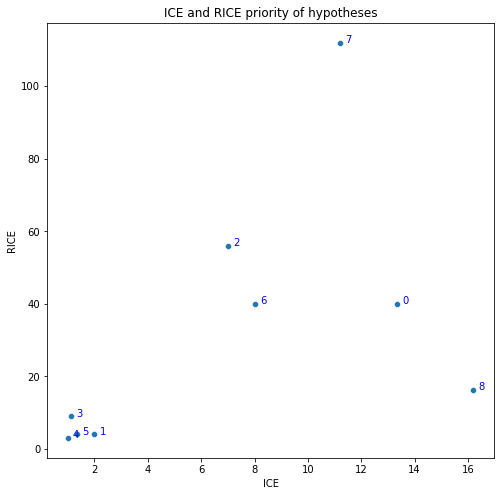

In [35]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=hypotheses['ICE'], y=hypotheses['RICE'])
for line in range(0, hypotheses.shape[0]):
    plt.text(hypotheses.ICE[line] +0.2, hypotheses.RICE[line], 
             hypotheses.index[line], horizontalalignment='left', size='medium', 
             color='blue')

plt.title('ICE and RICE priority of hypotheses')

plt.show()

<a id="conclusion2"></a>
### Conclusion

After running 2 methods and creating the scatterplot we saw that there's a difference between the results:

<b>ICE</b>
1. 8 - "*Launch a promotion that gives users discounts on their birthdays*"
2. 0 - "*Add two new channels for attracting traffic. This will bring 30% more users*"
3. 7 - "*Add a subscription form to all the main pages. This will help you compile a mailing list*"

<b>RICE</b>
1. 7 - "*Add a subscription form to all the main pages. This will help you compile a mailing list*"
2. 2 - "*Add product recommendation blocks to the store's site. This will increase conversion and average purchase size*"
3. 0 - "*Add two new channels for attracting traffic. This will bring 30% more users*"

The most unattractive hypothesis in both methods is 4th - "*Change the background color on the main page. This will increase user engagement*". Also 5th "*Add a customer review page. This will increase the number of orders*", 1st "*Launch your own delivery service. This will shorten delivery time*" and 3d "*Change the category structure. This will increase conversion since users will find the products they want more quickly*" have low ratings in both methods and will receive the lowest priority.

We saw that 8th hypothesis that was number one in ICE method didn't even make it in first 3 of RICE method. The main difference between two methods is an existence of "Reach" variable, which describes how many users will be affected by the update we want to introduce. And indeed, it sounds logical, that much less users will be affected, as in general only people who have birthday in the near future will be interested in this kind of promotion. While adding a subscription form to all main pages is an option for any kind of user. 

This way our top-priority hypotheses are: 7th, 0th and 2nd.

<a id="ab"></a>
## A/B test analysis

In this step we'll make a series of tests, comparing different aspects of data between the Control and the Test groups. We'll keep an eye for any anomalities in data, such as outliers, and will procede depending on the results.

<a id="cum_rev"></a>
### Cumulative revenue by group

Our first step will be calculating cumulative revenue. For this we'll create 2 grouped dfs: one for the control group `A` and another for the test group `B`. We're also going to calculate number of buyers, number of purchases and total sum of the revenue per day as we'll need this data later.

In [36]:
orders_ctrl = orders.query('group == "A"').groupby('date').agg({'revenue':'sum', 'transactionId':'nunique', 'visitorId':'nunique'}).reset_index()
orders_ctrl.columns = ['date', 'rev_sum', 'purchases', 'buyers']
orders_ctrl['cum_rev'] = orders_ctrl['rev_sum'].cumsum()
orders_ctrl.head()

,date,rev_sum,purchases,buyers,cum_rev
0,2019-08-01,2266.6,23,19,2266.6
1,2019-08-02,1468.3,19,18,3734.9
2,2019-08-03,1815.2,24,24,5550.1
3,2019-08-04,675.5,11,11,6225.6
4,2019-08-05,1398.0,22,22,7623.6


In [37]:
orders_test = orders.query('group == "B"').groupby('date').agg({'revenue':'sum', 'transactionId':'nunique', 'visitorId':'nunique'}).reset_index()
orders_test.columns = ['date', 'rev_sum', 'purchases', 'buyers']
orders_test['cum_rev'] = orders_test['rev_sum'].cumsum()
orders_test.head()

,date,rev_sum,purchases,buyers,cum_rev
0,2019-08-01,967.2,17,17,967.2
1,2019-08-02,2568.1,23,22,3535.3
2,2019-08-03,1071.6,14,14,4606.9
3,2019-08-04,1531.6,14,13,6138.5
4,2019-08-05,1449.3,21,21,7587.8


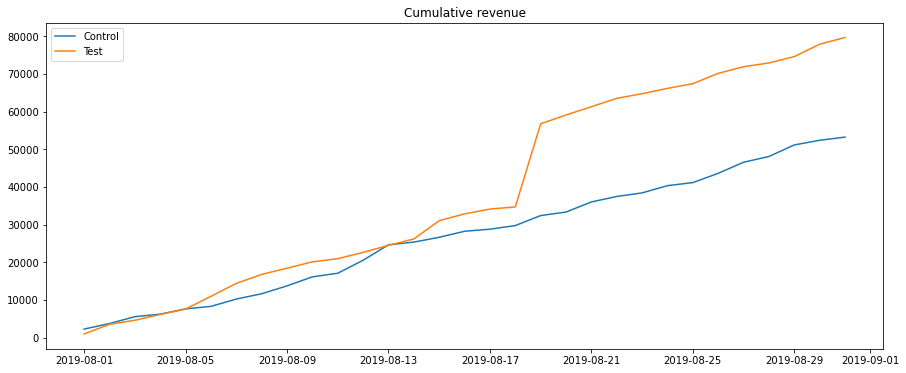

In [38]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(orders_ctrl['date'], orders_ctrl['cum_rev'], label='Control')
plt.plot(orders_test['date'], orders_test['cum_rev'], label='Test')
plt.title('Cumulative revenue')
plt.legend()

plt.show()

*Conclusion*: we can see that both lines start similarily low, test group being lower than the control group, and in about 5 days test group's cumulative revenue rises higher than control group's. Except for one point (13.08) after that test group's cumulative revenue continues to surpass the control group. There is also a rapid rise on about 18.08, which looks a bit suspicious: either there was a huge purchase on that day, or there were many orders placed on this day, anyway  and it looks like there's an outlier, so it is better to check that at a later step.

<a id="cum_order"></a>
### Cumulative average order size by group

Now let's take a look at the cumulated average order size.

In [39]:
orders_ctrl.head()

,date,rev_sum,purchases,buyers,cum_rev
0,2019-08-01,2266.6,23,19,2266.6
1,2019-08-02,1468.3,19,18,3734.9
2,2019-08-03,1815.2,24,24,5550.1
3,2019-08-04,675.5,11,11,6225.6
4,2019-08-05,1398.0,22,22,7623.6


In [40]:
orders_ctrl['cum_purch']=orders_ctrl['purchases'].cumsum()
orders_ctrl['cum_avg_check']=orders_ctrl['cum_rev']/orders_ctrl['cum_purch']
orders_ctrl.head()

,date,rev_sum,purchases,buyers,cum_rev,cum_purch,cum_avg_check
0,2019-08-01,2266.6,23,19,2266.6,23,98.547826
1,2019-08-02,1468.3,19,18,3734.9,42,88.926190
2,2019-08-03,1815.2,24,24,5550.1,66,84.092424
3,2019-08-04,675.5,11,11,6225.6,77,80.851948
4,2019-08-05,1398.0,22,22,7623.6,99,77.006061


In [41]:
orders_test['cum_purch']=orders_test['purchases'].cumsum()
orders_test['cum_avg_check']=orders_test['cum_rev']/orders_test['cum_purch']
orders_test.head()

,date,rev_sum,purchases,buyers,cum_rev,cum_purch,cum_avg_check
0,2019-08-01,967.2,17,17,967.2,17,56.894118
1,2019-08-02,2568.1,23,22,3535.3,40,88.382500
2,2019-08-03,1071.6,14,14,4606.9,54,85.312963
3,2019-08-04,1531.6,14,13,6138.5,68,90.272059
4,2019-08-05,1449.3,21,21,7587.8,89,85.256180


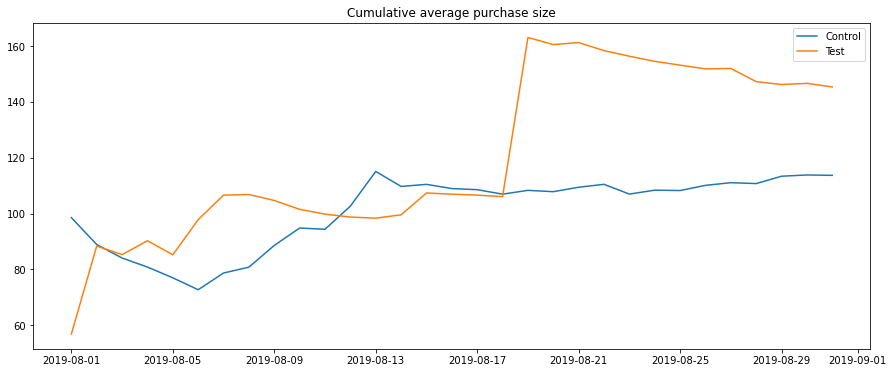

In [42]:
plt.plot(orders_ctrl['date'], orders_ctrl['cum_avg_check'], label='Control')
plt.plot(orders_test['date'], orders_test['cum_avg_check'], label='Test')
plt.title('Cumulative average purchase size')
plt.legend()

plt.show()

*Conclusion*: we can see that test group starts off much lower than control group, though pretty quickly it surpasses in cumulative average check, but the rise is unstable. We see that there are few picks that bring the test group's line above the control group line, one of them being the one that caused the line on cumulative revenue graph rise, which means that there was an acceptionally big purchase this day, or an outlier, which can actually be an obsticle in our analysis. Also we see that test group's line after that date has a slow drop in cumulative average check. 

On the other hand control group has a more stable rise and only few slight drops. The latest tendency of it's line is slow rise.

<a id="relative_avg"></a>
### Relative difference in cumulative average order size per group

Now let's see how the difference between the cumulative averages of both groups changes overtime.

In [43]:
mergedOrders = orders_ctrl[['date', 'cum_avg_check']].merge(orders_test[['date', 'cum_avg_check']], on='date', how='left', suffixes=['A', 'B'])
mergedOrders.head()

,date,cum_avg_checkA,cum_avg_checkB
0,2019-08-01,98.547826,56.894118
1,2019-08-02,88.926190,88.382500
2,2019-08-03,84.092424,85.312963
3,2019-08-04,80.851948,90.272059
4,2019-08-05,77.006061,85.256180


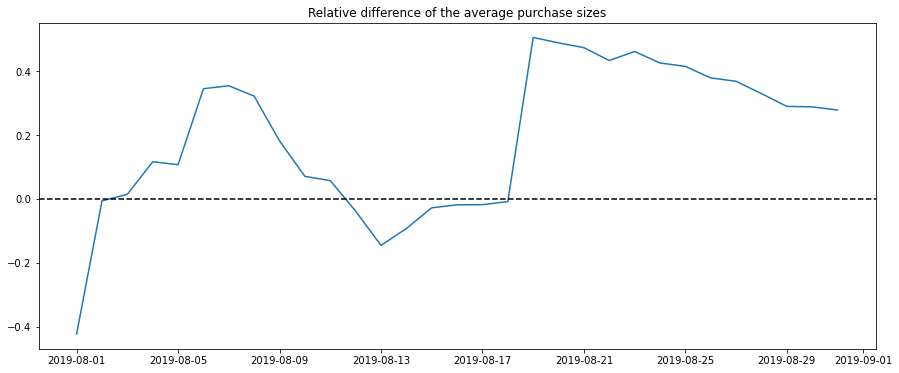

In [44]:
plt.plot(mergedOrders['date'], (mergedOrders['cum_avg_checkB'] / mergedOrders['cum_avg_checkA']) - 1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Relative difference of the average purchase sizes')

plt.show()

*Conclusion*: generally there's a positive difference between cumulative average checks, except in the middle the difference drops below zero, meaning the control group had bigger average purchase sizes. At two points on the graph we see that there are spikes, which means there must be some big orders and outliers. We'll be able to find them later. The latest tendency in difference is still a slight drop.

<a id="conversion"></a>
### Conversion rate per groups

To calculate the conversion rate we'll need to know the number of visits from `visits` table. For that purpose we'll merge our tables per date and group.

In [45]:
orders_ctrl = orders_ctrl.merge(visits.query('group == "A"'), on='date', how='left')
orders_ctrl['conversion'] = orders_ctrl['purchases'] / orders_ctrl['visits']
orders_ctrl.head()

,date,rev_sum,purchases,buyers,cum_rev,cum_purch,cum_avg_check,group,visits,conversion
0,2019-08-01,2266.6,23,19,2266.6,23,98.547826,A,719,0.031989
1,2019-08-02,1468.3,19,18,3734.9,42,88.926190,A,619,0.030695
2,2019-08-03,1815.2,24,24,5550.1,66,84.092424,A,507,0.047337
3,2019-08-04,675.5,11,11,6225.6,77,80.851948,A,717,0.015342
4,2019-08-05,1398.0,22,22,7623.6,99,77.006061,A,756,0.029101


In [46]:
orders_test = orders_test.merge(visits.query('group == "B"'), on='date', how='left')
orders_test['conversion'] = orders_test['purchases'] / orders_test['visits']
orders_test.head()

,date,rev_sum,purchases,buyers,cum_rev,cum_purch,cum_avg_check,group,visits,conversion
0,2019-08-01,967.2,17,17,967.2,17,56.894118,B,713,0.023843
1,2019-08-02,2568.1,23,22,3535.3,40,88.382500,B,581,0.039587
2,2019-08-03,1071.6,14,14,4606.9,54,85.312963,B,509,0.027505
3,2019-08-04,1531.6,14,13,6138.5,68,90.272059,B,770,0.018182
4,2019-08-05,1449.3,21,21,7587.8,89,85.256180,B,707,0.029703


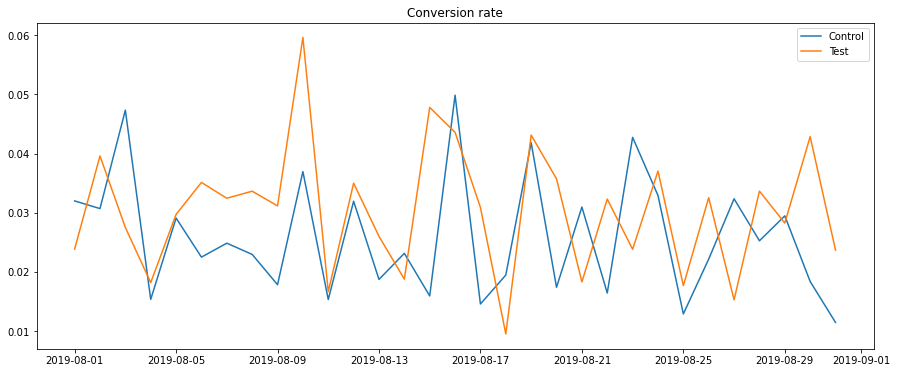

In [47]:
plt.plot(orders_ctrl['date'], orders_ctrl['conversion'], label='Control')
plt.plot(orders_test['date'], orders_test['conversion'], label='Test')
plt.title('Conversion rate')
plt.legend()

plt.show()

In [48]:
print('Overall conversion rate for group A:', orders_ctrl['purchases'].sum() / orders_ctrl['visits'].sum())
print('Overall conversion rate for group B:', orders_test['purchases'].sum() / orders_test['visits'].sum())

Overall conversion rate for group A: 0.02497865072587532
Overall conversion rate for group B: 0.02897018397124128


*Conclusion*: we don't see any prominent difference between the groups, both of them fluctuate every few days with greatest drops tending to be on the weekends. The overall conversion rate shows a slight difference in 0.004 points. We want to take a look at the relative difference in cumulative conversion rates, because based on the graph above only it is difficult to make conclusions. 

<b>Cumulative conversion</b>

In [49]:
orders_ctrl['cum_conversion'] = orders_ctrl['conversion'].cumsum()
orders_ctrl.head()

,date,rev_sum,purchases,buyers,cum_rev,cum_purch,cum_avg_check,group,visits,conversion,cum_conversion
0,2019-08-01,2266.6,23,19,2266.6,23,98.547826,A,719,0.031989,0.031989
1,2019-08-02,1468.3,19,18,3734.9,42,88.926190,A,619,0.030695,0.062684
2,2019-08-03,1815.2,24,24,5550.1,66,84.092424,A,507,0.047337,0.110021
3,2019-08-04,675.5,11,11,6225.6,77,80.851948,A,717,0.015342,0.125363
4,2019-08-05,1398.0,22,22,7623.6,99,77.006061,A,756,0.029101,0.154463


In [50]:
orders_test['cum_conversion'] = orders_test['conversion'].cumsum()
orders_test.head()

,date,rev_sum,purchases,buyers,cum_rev,cum_purch,cum_avg_check,group,visits,conversion,cum_conversion
0,2019-08-01,967.2,17,17,967.2,17,56.894118,B,713,0.023843,0.023843
1,2019-08-02,2568.1,23,22,3535.3,40,88.382500,B,581,0.039587,0.063430
2,2019-08-03,1071.6,14,14,4606.9,54,85.312963,B,509,0.027505,0.090935
3,2019-08-04,1531.6,14,13,6138.5,68,90.272059,B,770,0.018182,0.109117
4,2019-08-05,1449.3,21,21,7587.8,89,85.256180,B,707,0.029703,0.138820


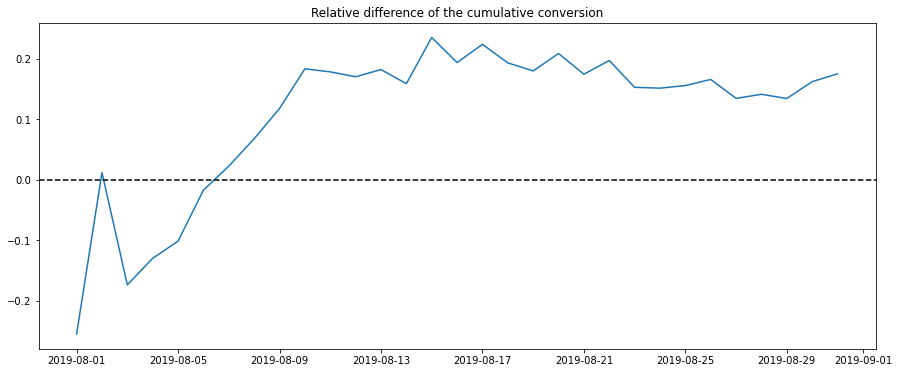

In [51]:
plt.plot(orders_ctrl['date'], (orders_test['cum_conversion'] / orders_ctrl['cum_conversion']) - 1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Relative difference of the cumulative conversion')

plt.show()

*Conclusion*: on this graph we can see it more clearly that the conversion rate of the test group is definetly higher than of the control group. Even though it has low ups and downs, after the 6th of August it stays bigger than that of the control group.

<a id="n_orders"></a>
### Number of orders per user

In [52]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [53]:
ordersByUsers = orders.groupby('visitorId').agg({'transactionId':'nunique', 'group':'first'}).reset_index()
ordersByUsers.columns = ['userId', 'purchases', 'group']
ordersByUsers.head()

,userId,purchases,group
0,5114589,1,B
1,6958315,1,B
2,11685486,1,A
3,39475350,1,B
4,47206413,1,B


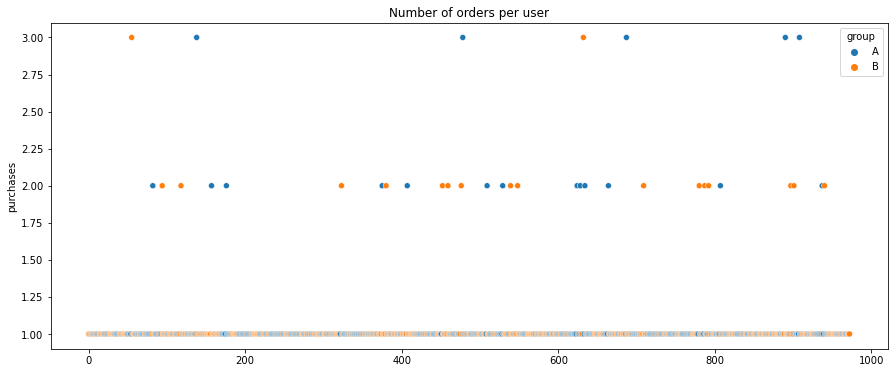

In [54]:
x_values = pd.Series(range(0,len(ordersByUsers)))
sns.scatterplot(x_values, ordersByUsers['purchases'], hue=ordersByUsers['group'])

plt.title('Number of orders per user')
plt.show()

*Conclusion*: we can see that absolute majority of users made only one purchase, and maximum number of purchases is three, which is very rare.

<b> Data anomalities </b>

As there are so few users that made 3 orders, let's take a look at the percentiles to check whether this can be considered an anomaly. We'll calculate the 95th and 99th percentiles for the number of orders per user.

We have too little value variety for boxplots, so we'll simply create a histogram and calculate percentiles.

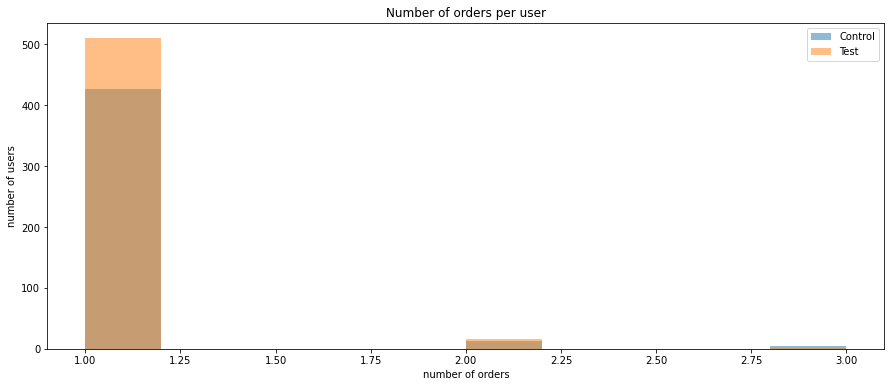

In [55]:
plt.hist(ordersByUsers.query('group == "A"')['purchases'], alpha=0.5, label="Control")
plt.hist(ordersByUsers.query('group == "B"')['purchases'], alpha=0.5, label="Test")

plt.legend()
plt.ylabel('number of users')
plt.xlabel('number of orders')
plt.title('Number of orders per user')

plt.show()

In [56]:
print('95% of orders are less or equal to:', np.percentile(ordersByUsers['purchases'], 95))
print('99% of orders are less or equal to:', np.percentile(ordersByUsers['purchases'], 99))

95% of orders are less or equal to: 1.0
99% of orders are less or equal to: 2.0


*Conclusion*: Both groups look pretty similar, 99% of the users have made 1 or 2 purchases, there's only 1% of users who have made 3 purchases. We will cut off this 1% of users for our filtered data.

<a id="order_price"></a>
### Order prices

We're going to take a look at the scatterplot of distribution of order prices.

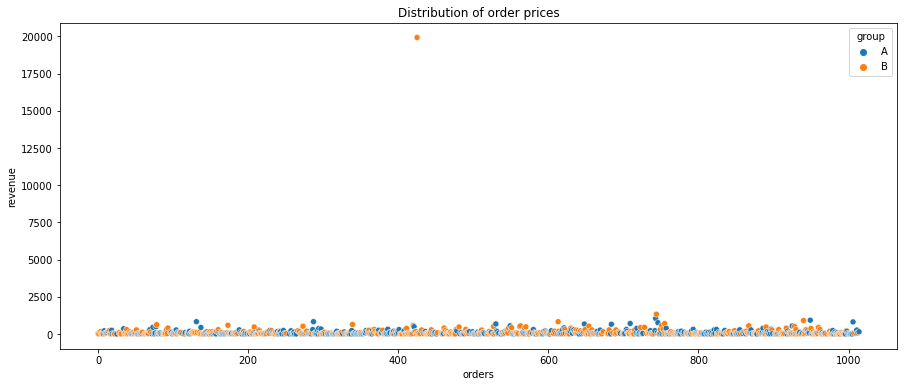

In [57]:
x_values = pd.Series(range(0,len(orders['revenue'])))

sns.scatterplot(x_values, orders['revenue'], hue=orders['group'])

plt.title('Distribution of order prices')
plt.ylabel('revenue')
plt.xlabel('orders')

plt.show()

In [58]:
print('Mean of the order price:', orders['revenue'].mean())
print('Median of the order price:', orders['revenue'].median())

Mean of the order price: 130.77086614173223
Median of the order price: 50.1


*Coclusion*: as we can see on the scatter plot, most of the purchase prices are pretty low, hovering above zero, but we have one dot that is way above everything else, obviously an outlier. Additionally, looking at the difference between mean and median, we can tell how much this outlier (and possibly other less visible ones) influences the results. We'll need to take a closer look using percentiles in order to get a clean dataset.

<b> Data anomalities</b>

At first, let's take a look at the boxplots for two groups seperately to have a better view what differences we have between our groups. We're setting `ylim` parameter for the test group, as the outlier which we saw above originates from this group, as well as several other outliers, which make it difficult to properly look at the plot.

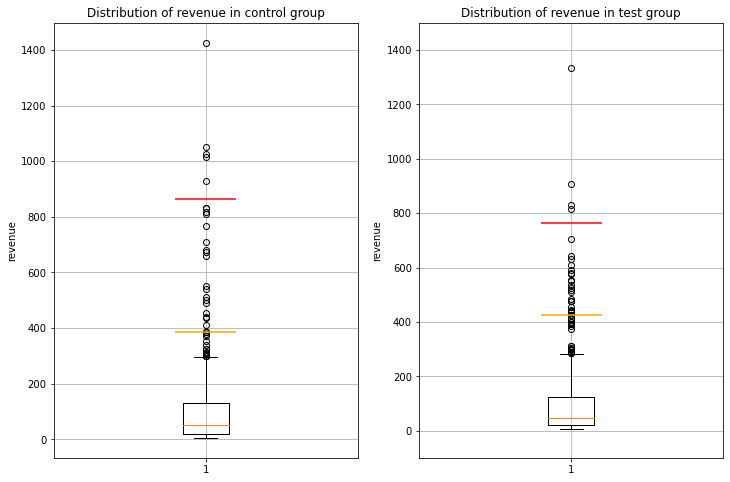

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

ax[0].boxplot(orders.query('group == "A"')['revenue'])
ax[0].hlines(y = np.percentile(orders.query('group == "A"')['revenue'], 95), xmin=0.9, xmax=1.1, color='orange')
ax[0].hlines(y = np.percentile(orders.query('group == "A"')['revenue'], 99), xmin=0.9, xmax=1.1, color='red')

ax[0].set_title('Distribution of revenue in control group')
ax[0].set_ylabel('revenue')

ax[0].grid()

ax[1].boxplot(orders.query('group == "B"')['revenue'])
ax[1].hlines(y = np.percentile(orders.query('group == "B"')['revenue'], 95), xmin=0.9, xmax=1.1, color='orange')
ax[1].hlines(y = np.percentile(orders.query('group == "B"')['revenue'], 99), xmin=0.9, xmax=1.1, color='red')

ax[1].set_title('Distribution of revenue in test group')
ax[1].set_ylabel('revenue')
ax[1].set_ylim(-100, 1500)

ax[1].grid()

plt.show()

Now for the whole data:

In [60]:
print('95% of order prices are less or equal to:', np.percentile(orders['revenue'], 95))
print('99% of order prices are less or equal to:', np.percentile(orders['revenue'], 99))

95% of order prices are less or equal to: 414.275
99% of order prices are less or equal to: 830.3


*Conclusion*: there doesn't seem to be significant difference between the two groups at this stage too, the main bodies of data look almost identical, while there is a difference in outliers. Though, this is 1% of data only that makes the biggest difference and it is too small to make firm conclusions, but the outliers are too extreme and influence our data, as we saw earlier. It will be better to cut off 1-5% of data for more reliable results.

<a id="stat_sign"></a>
###  Comparison of statistical significance between raw and filtered data

<a id="conversion_raw"></a>
#### Raw data. Statistical significance of the difference in conversion between the groups

Now we'll check statistical significance of the difference in overall conversion between groups in the raw data. For that we'll use `stats.mannwhitneyu` test as we've detected several data anomalities.

We'll take alpha 0.05.

* H0 is that there is no statistical significance in the difference between conversions of the two groups.
* H1 is that there is statistical significance in the difference between conversions of the two groups.

In [61]:
def test_conversion(before, after, alpha):

    stat, pval = stats.mannwhitneyu(before, after)
    if pval < alpha:
        print('P-value: {0:0.3f}, reject H0: there is statistical significance in the difference between conversions of the two groups'.format(pval))
    else:
        print('P-value: {0:0.3f}, fail to reject H0: there is no statistical significance in the difference between conversions of the two groups'.format(pval))

In [62]:
test_conversion(orders_ctrl['conversion'], orders_test['conversion'], 0.05)

P-value: 0.054, fail to reject H0: there is no statistical significance in the difference between conversions of the two groups


*Conclusion*: if we analyze the raw data we get 0.027 as p-value, which comparing to alpha 0.05 is less, meaning we can  reject the null hypothesis, and say that there is statistical significance in difference of conversion between the control and the test groups. We will compare this result to the test on filtered data.

Let's also take a look at the distribution of data for average daily conversion per groups on a graph.

<b>Average daily conversion</b>

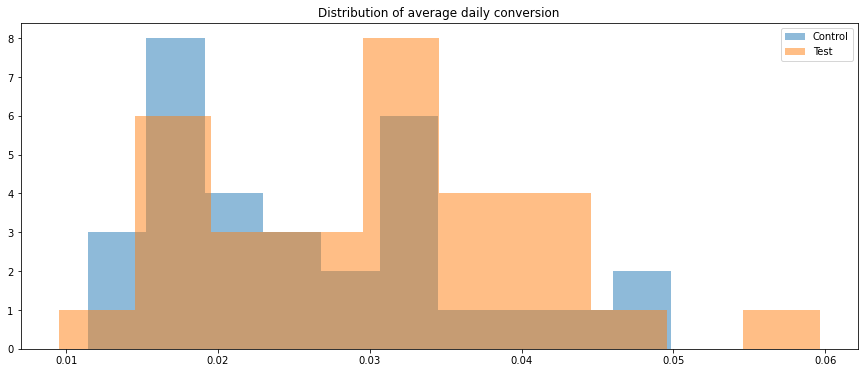

In [63]:
plt.hist(orders_ctrl['conversion'], alpha=0.5, label='Control')
plt.hist(orders_test['conversion'], alpha=0.5, label='Test')

plt.legend(loc='upper right')
plt.title('Distribution of average daily conversion')
plt.show()

*Conclusion*: the graph shows us that the test group has bigger conversion rate than the control group.

<a id="order_size_raw"></a>
#### Raw data. Statistical significance of the difference in average order size between the groups

At first, we're going to calculate the average check for both tables.

In [64]:
orders_ctrl['avg_check'] = orders_ctrl['rev_sum'] / orders_ctrl['purchases']
orders_ctrl.head()

,date,rev_sum,purchases,buyers,cum_rev,cum_purch,cum_avg_check,group,visits,conversion,cum_conversion,avg_check
0,2019-08-01,2266.6,23,19,2266.6,23,98.547826,A,719,0.031989,0.031989,98.547826
1,2019-08-02,1468.3,19,18,3734.9,42,88.926190,A,619,0.030695,0.062684,77.278947
2,2019-08-03,1815.2,24,24,5550.1,66,84.092424,A,507,0.047337,0.110021,75.633333
3,2019-08-04,675.5,11,11,6225.6,77,80.851948,A,717,0.015342,0.125363,61.409091
4,2019-08-05,1398.0,22,22,7623.6,99,77.006061,A,756,0.029101,0.154463,63.545455


In [65]:
orders_test['avg_check'] = orders_test['rev_sum'] / orders_test['purchases']
orders_test.head()

,date,rev_sum,purchases,buyers,cum_rev,cum_purch,cum_avg_check,group,visits,conversion,cum_conversion,avg_check
0,2019-08-01,967.2,17,17,967.2,17,56.894118,B,713,0.023843,0.023843,56.894118
1,2019-08-02,2568.1,23,22,3535.3,40,88.382500,B,581,0.039587,0.063430,111.656522
2,2019-08-03,1071.6,14,14,4606.9,54,85.312963,B,509,0.027505,0.090935,76.542857
3,2019-08-04,1531.6,14,13,6138.5,68,90.272059,B,770,0.018182,0.109117,109.400000
4,2019-08-05,1449.3,21,21,7587.8,89,85.256180,B,707,0.029703,0.138820,69.014286


For this step we'll write a function that checks both groups for normality with the help of Shapiro-Wilk test, and if the data has normal distribution, then we'll perform t-test, if not, then we'll perform Wilcoxon-Mann-Whitney test. In case t-test is being performed, we'll check at first the equality of variances by Levene's test.

alpha = 0.05

* H0 is that there's no statistical significance of the difference in average order size between the groups.
* H1 is that there is statistical significance of the difference in average order size between the groups.

In [66]:
def testing_average(sample1,sample2,alpha=0.05):
    #checking normality
    sample1=sample1.dropna()
    sample2=sample2.dropna()
    stat1, p1_norm=stats.shapiro(sample1)
    stat2, p2_norm=stats.shapiro(sample2)
    if p1_norm > alpha and p2_norm>alpha:
        #then both normal, perform t-test.
        #for t-test also should check the equality of variances
        statslev,p_levene=stats.levene(sample1, sample2)
        if p_levene<alpha:
           #variances are not equal
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=False)
        else:
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=True) 
    else:
        statist,p_value=stats.mannwhitneyu(sample1, sample2)
    print('The p-value is:', p_value)
    if p_value<alpha:
        print('Reject H0: there is statistical significance of the difference in average order size between the groups')
    else:
        print('Fail to Reject H0: there is no statistical significance of the difference in average order size between the groups')

In [67]:
print('Mean average check of the control group:', orders_ctrl['avg_check'].mean())
print('Mean average check of the test group:', orders_test['avg_check'].mean())

Mean average check of the control group: 115.51247176082741
Mean average check of the test group: 138.37116968351648


In [68]:
testing_average(orders_ctrl['avg_check'],orders_test['avg_check'],alpha=0.05)

The p-value is: 0.9550914317372012
Fail to Reject H0: there is no statistical significance of the difference in average order size between the groups


*Conclusion*: even though the calculated above mean average checks look different, we failed to reject the null hypothesis, meaning that according to results from the raw data, there's no evidence that this difference has any statistical significance. It is important to run an additional test on filtered data and compare the results.

<a id="filtering"></a>
#### Filtering the data

For the next steps we need to remove the anomalities we've discovered earlier from our data. Then we'll run same tests as in previous steps and compare the results.

As we've been working on grouped data with no explicit user ids, we'll have to start from the beginning, from cleaning `orders` dataset, then group it and create lacking columns.

At first let's create a list of anomal user ids we want to remove from our data. We're removing users that made more than 2 purchases and users that have order sizes more than 95th percentile, which is 414.

In [69]:
anomal_id_listed = ordersByUsers.query('purchases > 2')['userId'].tolist() + orders.query('revenue > 415')['visitorId'].tolist()
anomal_id_listed

[249864742,
 611059232,
 2108163459,
 2742574263,
 2988190573,
 3908431265,
 3967698036,
 2947100995,
 787824685,
 3288820196,
 2254586615,
 1211585711,
 2953427180,
 3118156181,
 2278620397,
 2254456485,
 834731816,
 1606766439,
 1357170471,
 1920142716,
 3177790019,
 2837914161,
 2912540959,
 1367935136,
 1010866419,
 1452540367,
 935349363,
 113298937,
 2247666522,
 3931967268,
 382846391,
 816783716,
 358944393,
 950626008,
 4009017467,
 3357398384,
 4133034833,
 888512513,
 3321013705,
 689129267,
 2279926127,
 3372131337,
 2853587382,
 2840985286,
 204675465,
 4003628586,
 887908475,
 2999642019,
 2261934787,
 1605520752,
 3590655705,
 148427295,
 1164614297,
 1604853044,
 1307669133,
 759473111,
 2606908679,
 2108080724]

Let's check the number of rows before we'll get rid of these ids and after.

In [70]:
len(orders)

1016

In [71]:
new_orders = orders.query('visitorId not in @anomal_id_listed')
len(new_orders)

943

Ok. Now we'll create new grouped tables and columns we'll need for analysis.

In [72]:
new_orders_ctrl = new_orders.query('group == "A"').groupby('date').agg({'revenue':'sum', 'transactionId':'nunique', 'visitorId':'nunique'}).reset_index()
new_orders_ctrl.columns = ['date', 'revenue', 'purchases', 'buyers']
new_orders_ctrl = new_orders_ctrl.merge(visits.query('group == "A"'), on='date', how='left')
new_orders_ctrl['conversion'] = new_orders_ctrl['buyers'] / new_orders_ctrl['visits']
new_orders_ctrl['avg_check'] = new_orders_ctrl['revenue'] / new_orders_ctrl['purchases']
new_orders_ctrl.head()

,date,revenue,purchases,buyers,group,visits,conversion,avg_check
0,2019-08-01,883.2,16,15,A,719,0.020862,55.200000
1,2019-08-02,1438.3,18,17,A,619,0.027464,79.905556
2,2019-08-03,1815.2,24,24,A,507,0.047337,75.633333
3,2019-08-04,675.5,11,11,A,717,0.015342,61.409091
4,2019-08-05,1398.0,22,22,A,756,0.029101,63.545455


In [73]:
new_orders_test = new_orders.query('group == "B"').groupby('date').agg({'revenue':'sum', 'transactionId':'nunique', 'visitorId':'nunique'}).reset_index()
new_orders_test.columns = ['date', 'revenue', 'purchases', 'buyers']
new_orders_test = new_orders_test.merge(visits.query('group == "B"'), on='date', how='left')
new_orders_test['conversion'] = new_orders_test['buyers'] / new_orders_test['visits']
new_orders_test['avg_check'] = new_orders_test['revenue'] / new_orders_test['purchases']
new_orders_test.head()

,date,revenue,purchases,buyers,group,visits,conversion,avg_check
0,2019-08-01,967.2,17,17,B,713,0.023843,56.894118
1,2019-08-02,1502.5,21,20,B,581,0.034423,71.547619
2,2019-08-03,1071.6,14,14,B,509,0.027505,76.542857
3,2019-08-04,1046.3,13,12,B,770,0.015584,80.484615
4,2019-08-05,1009.1,20,20,B,707,0.028289,50.455000


#### The statistical significance of the difference in conversion between the groups using the filtered data

Now we're ready to calculate the statistical significance.

Alpha = 0.05.

* H0 is that there is no statistical significance in the difference between conversions of the two groups.
* H1 is that there is statistical significance in the difference between conversions of the two groups.

In [74]:
test_conversion(new_orders_ctrl['conversion'], new_orders_test['conversion'], 0.05)

P-value: 0.031, reject H0: there is statistical significance in the difference between conversions of the two groups


*Conclusion*: the p-value we've got from filtered data is till smaller than alpha, and is even smaller than with the raw data, meaning that there is statistical significance in the difference between conversions of the two groups. 

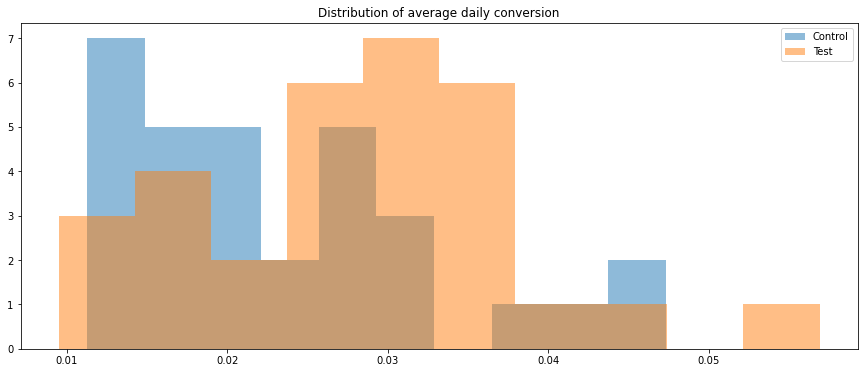

In [75]:
plt.hist(new_orders_ctrl['conversion'], alpha=0.5, label='Control')
plt.hist(new_orders_test['conversion'], alpha=0.5, label='Test')

plt.legend(loc='upper right')
plt.title('Distribution of average daily conversion')
plt.show()

*Conclusion*: we can see it more clearly now on the histogram that test group has a greater daily conversion that the control group.

<a id="order_size_filt"></a>
#### Filtered data. Statistical significance of the difference in average order size between the groups

For this analysis we can use the function we've created previously for the raw data.

alpha = 0.05

* H0 is that there's no statistical significance of the difference in average order size between the groups.
* H1 is that there is statistical significance of the difference in average order size between the groups.

In [76]:
print('Mean average check of control group:', new_orders_ctrl['avg_check'].mean())
print('Mean average check of test group:', new_orders_test['avg_check'].mean())

Mean average check of control group: 83.61238443445102
Mean average check of test group: 79.44670436227887


In [77]:
testing_average(new_orders_ctrl['avg_check'],new_orders_test['avg_check'],alpha=0.05)

The p-value is: 0.4141814844895094
Fail to Reject H0: there is no statistical significance of the difference in average order size between the groups


*Conclusion*: after filtering the data our mean average checks changed quite a bit, there's also less visible difference between them, and again the test showed that we failed to reject the null hypothesis, so there's no statistical significance of the difference in average order size between our groups.

<a id="conclusion3"></a>
## Overall conclusion

Before getting to the main part of the analysis it is important to note which chellenges we've had with given data. While preparing data for our analysis, we've made severall small changes to the data, like changing data types. There was no missing data, but we've discovered that there were users that were present in both A and B groups, which is a serious issue for an A\B test. Thankfully, there were not that many users, so we've dropped them and continued, but this issue has to be checked with Q&A team.

At the first part of our analysis we've prioritized hypotheses that we've compiled together with marketing department. The goal of these hypotheses is to boost the revenue. At the start we've had 9 hypotheses, and we used two methods to priorityze them, `ICE` and `RICE` methods. The difference between the 2 methods is that `RICE` method also takes into account `Reach` parameter, which is very important for an online store.

After comparing the results of the 2 methods which were slightly different, we've decided upon top3 of hypotheses to biist the revenue. We've also noted which hypotheses are least worthy of attention.

Top3:
* 7th - *Adding a subscription form to all the main pages, which will help you compile a mailing list*
* 0th - *Adding two new channels for attracting traffic, which will bring 30% more users*
* 2nd - *Adding product recommendation blocks to the store's site, which will increase conversion and average purchase size*
These 3 hypotheses are not only most promising in terms of boosting the revenue, they are also top in reaching as many users as possible.

The second part of our analysis consisted of running different tests on the results we've gor from A\B testing so far. 
1) Both cumulative revenue and cumulative average purchase size showed us that overall test group performed better, but we've noticed that there are some outliers that influence the picture. 
2) The conversion rate was difficult to analyse on graph, it didn't look much different: for both groups it is highly zigzaged, with rapid rises and falls every few days.
3) The number of orders per user in 95% of cases is 1. We've had several users that made 3 orders, but those turned out to be outliers.
4) The revenue per order sisn't look much different for the 2 groups, and we've also found some outliers, which we've cleared at a later stage.

After running tests checking whether there was statistical significance of the difference in conversion rate and average order size between the groups we've received next results:

1) There is no statistical significance of the difference in average order size between the groups. We've also seen that on the boxplots, the shapes of data, excluding outliers, was almost identical.

2) There is statistical significance of the difference in conversion rate. After the test  we've built additionally a histogram showing average daily conversion and again we saw that the test group performs better than the control group. 

<b> Recommendations for business:</b>

1. After prioritizing hypotheses we've created with marketing department we present top-prioty hypotheses:
    * 7th - *Adding a subscription form to all the main pages, which will help you compile a mailing list*
    * 0th - *Adding two new channels for attracting traffic, which will bring 30% more users*
    * 2nd - *Adding product recommendation blocks to the store's site, which will increase conversion and average purchase size*

On the other hand hypotheses that we don't recommend to fullfill:
   * 4th - *Change the background color on the main page, which will increase user engagement*
   * 5th - *Add a customer review page, which will increase the number of orders*
   * 1st - *Launch your own delivery service, which will shorten delivery time*
   * 3rd - *Change the category structure, which will increase conversion since users will find the products they want more quickly*
    
2. The A/B test can be stopped at this point, these are the tips considering the results:
    * It is best to address the issue of duplicate ids in both groups to learn the origin of this error and correct it in future. We are ready to provide the list of corrupted ids to QA team.
    * The test group proved to have greater conversion rate, it will be more profitable to apply the conditions of this group for all users.
    * Pay attention that we found no evidence that the average check rose in the test group, only the conversion rate.